In [143]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
import gseapy as gp
import re
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette

def label_sample(x):
    if 'HS' in x:
        return 'High salt'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('N[aA]', x):
        return 'Alkaline hydrolysis'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('Exo|ED|DE', x):
        return 'Exonuclease I'
    elif 'All' in x:
        return 'Untreated'
    else:
        return 'Unfragmented'

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)
colors = okabeito_palette()
colors.append('black')

In [144]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
count_file = project_path + '/Counts/combined_gene_count.tsv'
#    .assign(grouped_type = lambda d: np.where(d.name.str.startswith('MT-'), 'MT', d.grouped_type))\


count_df = pd.read_table(count_file) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))
count_df.head()

,id,grouped_type,type,name,200FN_1_S3_R1_001,200FQ_1_S4_R1_001,200NDP_1_S5_R1_001,200ND_1_S6_R1_001,200ND_2_S7_R1_001,200NH_1_S8_R1_001,...,Qcf_HS3_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,Qcf_NA2_R1_001,Qcf_Na1_R1_001,S96_cfD_R1_001,S96_cf_R1_001,TEV1_R1_001,TEV2_R1_001,TEV3_R1_001
0,18S_rRNA,rRNA,rDNA,18S_rRNA,626746.5,795566.0,206622.5,70107.0,161960.5,150410.5,...,39680.0,1147.0,824.0,1030.5,1016.5,52537.0,56350.5,250239.5,1029894.5,2059.0
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1318143.5,1338619.0,523739.0,152026.5,350603.0,321675.5,...,84982.5,7028.0,9546.0,1988.5,2178.0,138177.0,147736.0,531385.5,1640763.5,2320.5
2,5.8S_rRNA,rRNA,rDNA,5.8S_rRNA,58194.5,55894.0,36639.5,92652.5,222217.5,171202.5,...,55165.5,192.0,96.0,121.5,159.5,181095.0,193163.5,500432.5,90813.0,30.5
3,5S_rRNA,rRNA,rDNA,5S_rRNA,24427.5,81433.5,13364.5,11100.5,32791.5,27038.0,...,7249.0,133.5,37.5,57.5,85.0,1678.5,1773.5,18994.0,26173.0,6.0
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
count_df.columns

Index(['id', 'grouped_type', 'type', 'name', '200FN_1_S3_R1_001',
       '200FQ_1_S4_R1_001', '200NDP_1_S5_R1_001', '200ND_1_S6_R1_001',
       '200ND_2_S7_R1_001', '200NH_1_S8_R1_001', '200NIIIP_1_S1_R1_001',
       '200NIII_1_S9_R1_001', '200NIP_1_S10_R1_001', '200NI_1_S11_R1_001',
       '200PND_1_S12_R1_001', '200PNIII_1_S16_R1_001', '200PNI_1_S13_R1_001',
       '200_H_2_S10_R1_001', '200_H_S3_R1_001', '200_III_2_S9_R1_001',
       '200_III_S2_R1_001', '200_I_2_S6_R1_001', '200_I_3_S8_R1_001',
       '200_I_S1_R1_001', '200_NT_2_S5_R1_001', '200_NT_3_S7_R1_001',
       '200_NT_S5_R1_001', '200_PI_1_S11_R1_001', '450FPN_1_S14_R1_001',
       '450_NT_1_S4_R1_001', '450_NT_2_S6_R1_001', 'IGG_cf_R1_001',
       'NN2_R1_001', 'NQ1_R1_001', 'NQ2_R1_001', 'ON1_R1_001', 'ON2_R1_001',
       'OQ1_R1_001', 'QCF1_R1_001', 'QCF2_R1_001', 'Qcf10_R1_001',
       'Qcf4_R1_001', 'Qcf5_R1_001', 'Qcf6_SS_R1_001', 'Qcf7_R1_001',
       'Qcf8_R1_001', 'Qcf9_R1_001', 'Qcf_All1_R1_001', 'Qcf_DE1_R1_001

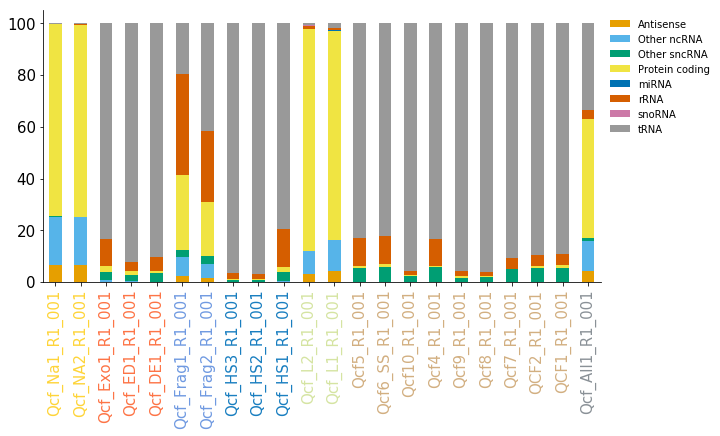

In [146]:
def percentage_columns(d):
    for col in d.columns:
        d[col] = d[col].transform(lambda x: 100*x/x.sum())
    return d

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
bar_df = count_df.drop(['id','type','name'], axis=1)\
    .filter(regex = 'grouped|Q[cC][fF]')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .assign(treatment = lambda d: d.index.map(label_sample))
    
bar_df.sort_values('treatment')\
    .drop('treatment', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)

ce = color_encoder()
ce.fit_transform(bar_df.treatment, simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
sns.despine()

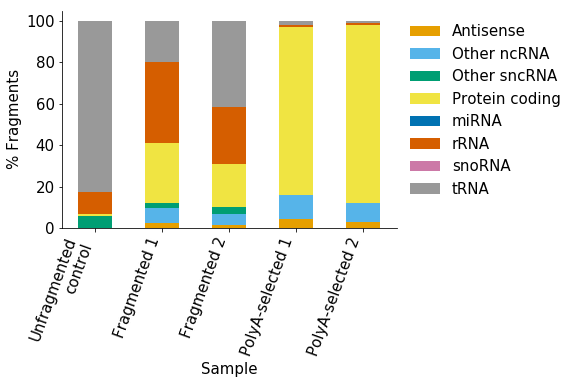

In [147]:
def rename_longRNA(name):
    try:
        x = name.split('_')[1]
        treatment = ''
    
        is_long = 0
        if 'Frag' in x:
            treatment = 'Fragmented'
            is_long = 1
        elif re.search('L[12]', x):
            treatment = 'PolyA-selected'
            is_long = 1
        elif re.search('Qcf[0-9]+|SS',name):
            treatment = 'Unfragmented\ncontrol'
            is_long = 0
    
        if is_long == 1:
            return treatment +' ' + re.search('\d+', x).group(0)
        else:
            return treatment 
    except IndexError:
        return name
        

fig = plt.figure()
ax = fig.add_subplot(111)
count_df\
    .filter(regex = 'grouped|L[12]|Frag|SS')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .rename(columns = rename_longRNA)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False, fontsize=15)
ax.set_xlabel('Sample')
ax.set_ylabel('% Fragments')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
sns.despine()

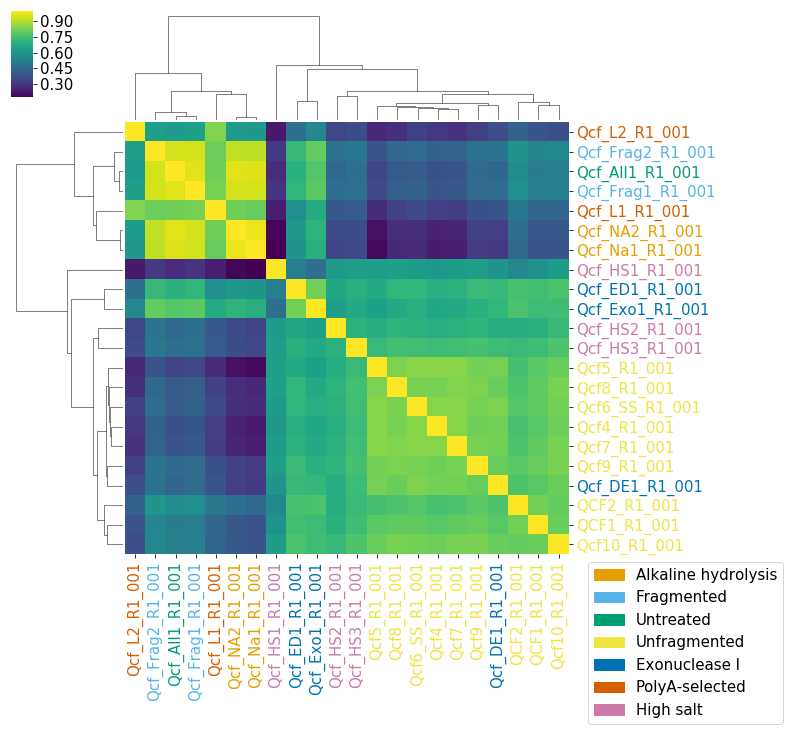

In [148]:
cor_df = np.log(count_df.filter(regex = 'Qcf|QCF')+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

In [149]:
def count_to_tpm(count, length):
    rate = count/length
    tpm = rate/rate.sum() * 1e6 
    return tpm

gene_length = pd.read_table('/stor/work/Lambowitz/ref/hg19/genome/genes.length', 
                            names = ['id','glength'])
gene_length.head()

tpm_df = count_df\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .merge(gene_length)
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])

In [150]:
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr)
expr_df.head()

,Gene,Gene name,Sample,Value,Unit
0,ENSG00000000003,TSPAN6,adipose tissue,31.5,TPM
1,ENSG00000000003,TSPAN6,adrenal gland,26.4,TPM
2,ENSG00000000003,TSPAN6,appendix,9.2,TPM
3,ENSG00000000003,TSPAN6,bone marrow,0.7,TPM
4,ENSG00000000003,TSPAN6,breast,53.4,TPM


In [151]:
top_n = 80
tpm_cor_df = tpm_df\
    .filter(regex='id|Qcf')\
    .rename(columns = {'id':'Gene'})
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene'], values='Value') \
    .reset_index() \
    .merge(tpm_cor_df, on ='Gene', how ='inner')\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .iloc[:, 1:]\
    .transform(lambda x: np.log(x+1))\
    .corr(method = 'pearson')\
    .filter(regex = 'Qcf|Frag') \
    .reset_index() \
    .pipe(lambda d: d[~d['index'].str.contains('Qcf')])\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .head(top_n)
cor_df.index = cor_df['index']
cor_df

,index,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
index,,,,,
bone marrow,bone marrow,0.102779,0.109257,0.334730,0.358415
lymph node,lymph node,0.076665,0.086123,0.301621,0.320091
spleen,spleen,0.082834,0.091645,0.300821,0.319556
appendix,appendix,0.081310,0.091743,0.298064,0.316949
tonsil,tonsil,0.077977,0.088952,0.295411,0.311715
salivary gland,salivary gland,0.114882,0.123227,0.290324,0.316465
colon,colon,0.091283,0.103432,0.284115,0.306500
adipose tissue,adipose tissue,0.091187,0.101717,0.283359,0.301339
urinary bladder,urinary bladder,0.077475,0.088699,0.280273,0.296395


Text(1,0.6,"Spearman's $\\rho$")

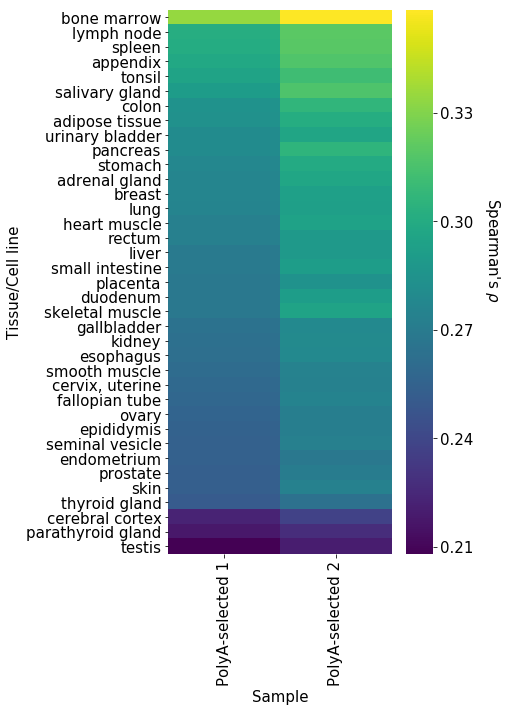

In [152]:
fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(111)
sns.heatmap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
           cmap = 'viridis', ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line')
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=15)
fig.text(1,0.6, r"Spearman's $\rho$", rotation = 270, fontsize=15)

Text(0.08,0.85,"Spearman's $\\rho$")

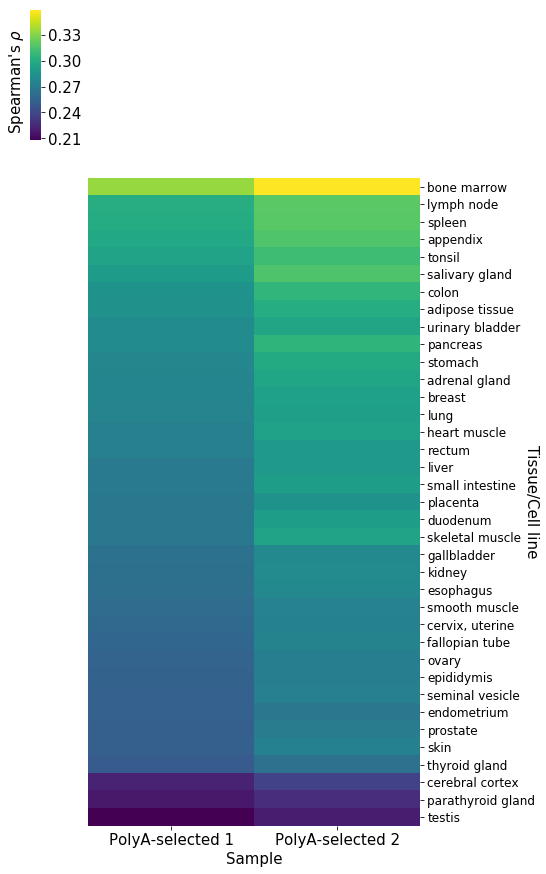

In [153]:
p = sns.clustermap(cor_df.filter(regex = 'L[12]').rename(columns = rename_longRNA),
                row_cluster=False,
                col_cluster=False,
               cmap = 'viridis',
               figsize = (7,15))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_yticklabels(cor_df['index'].values, fontsize=12)#[p.dendrogram_row.reordered_ind])
ax.set_xlabel('Sample')
ax.set_ylabel('Tissue/Cell line', rotation=270)
p.fig.text(0.08,0.85, r"Spearman's $\rho$", rotation = 90, fontsize=15)

In [154]:
tpm_df.head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
0,18S_rRNA,rRNA,rDNA,18S_rRNA,795566.0,24968.067815,11415.338098,1091.021658,729.343057,1870
1,28S_rRNA,rRNA,rDNA,28S_rRNA,1338619.0,15360.535758,6400.700364,2483.305223,3138.733674,5034
2,5S_rRNA,rRNA,rDNA,5S_rRNA,81433.5,31150.043639,15654.382932,1978.844099,517.244962,120
3,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.000000,0.000000,0.000000,0.000000,11321
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.120967,0.037478,0.471355,0.146205,11321


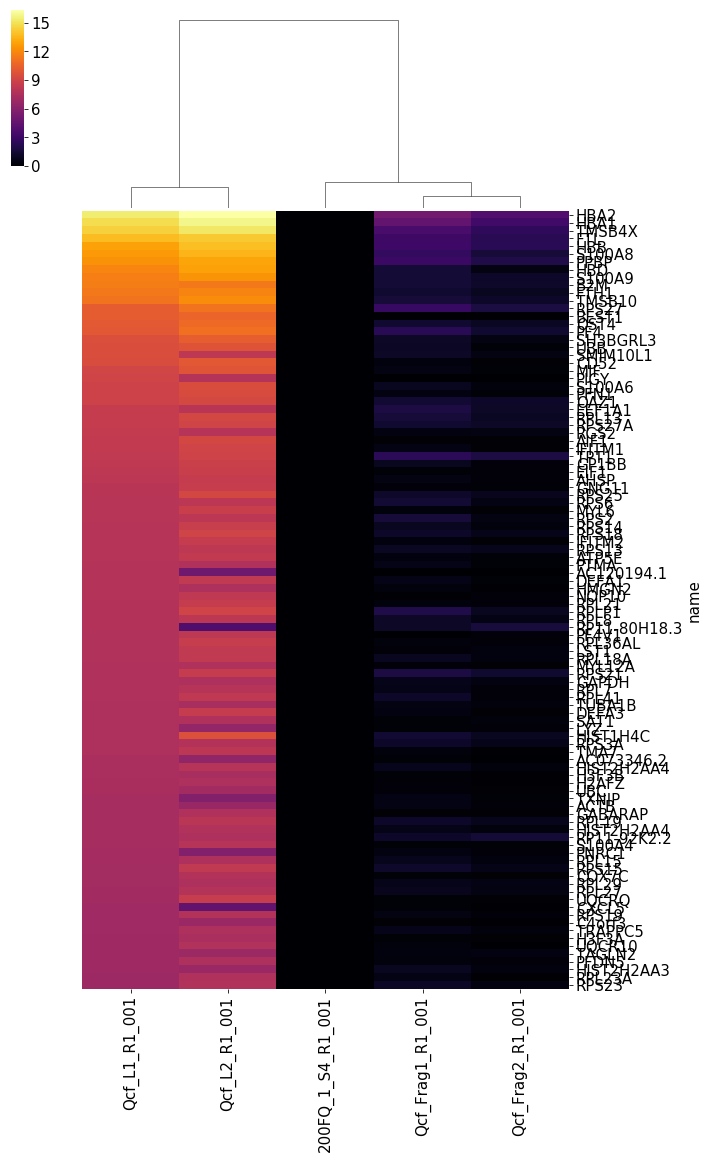

In [155]:
top_n = 100
hd = tpm_df\
    .sort_values('Qcf_L1_R1_001', ascending=False)\
    .query('type == "protein_coding"')\
    .pipe(lambda d: d[~d.name.str.contains('^MT')])
hd.index = hd.name

p = sns.clustermap(np.log2(hd\
                           .head(top_n)\
                           .filter(regex = 'Q')+1),
              row_cluster=False,
              cmap='inferno',
              figsize = (10,18))
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n) +0.5)
yt = ax.set_yticklabels(hd.index[:top_n])

In [156]:
samplename = 'Qcf_L1_R1_001'

tpm_df = count_df\
    .assign(id = lambda d: d.id.str.split('.', expand=True).iloc[:,0])\
    .filter(regex='id|grouped_type|type|name|L[12]|Frag|FQ') \
    .merge(gene_length) \
    .query('type == "protein_coding"')
for col in tpm_df.columns:
    if 'Qcf' in col:
        tpm_df[col] = count_to_tpm(tpm_df[col], tpm_df['glength'])
tpm_df.sort_values('Qcf_L1_R1_001', ascending=False).head()


rank_df = expr_df\
    .pipe(lambda d: d[np.in1d(d.Sample, ['bone marrow', 'lymph node', 'spleen'])])\
    .rename(columns = {'Gene':'id',
                       'Gene name':'name'})\
    .groupby(['id','name'], as_index=False)\
    .agg({'Value':'mean'})\
    .filter(['id','name','Value'])\
    .merge(hd\
            .loc[:,['id','name',samplename]],
          on = ['id','name']) \
    .assign(rank = lambda d: d[samplename].rank() - d['Value'].rank()) \
    .sort_values('rank', ascending=False)
rank_df.head(20)

,id,name,Value,Qcf_L1_R1_001,rank
36323,ENSG00000255072,PIGY,0.0,535.267859,34890.0
36918,ENSG00000267697,LUZP6,0.0,70.745192,34751.0
11508,ENSG00000127530,OR7C1,0.0,26.722798,34513.0
34133,ENSG00000206106,KRTAP22-2,0.0,24.366250,34475.0
28260,ENSG00000180934,OR56A1,0.0,21.610814,34429.0
17672,ENSG00000148826,NKX6-2,0.0,21.192251,34419.0
24804,ENSG00000170790,OR10A2,0.0,20.289767,34400.0
36320,ENSG00000255012,OR5M1,0.0,16.904569,34341.0
36683,ENSG00000260836,RP11-152F13.10,0.0,16.334077,34322.0
34861,ENSG00000221836,OR2A5,0.0,14.061156,34246.5


In [157]:
cor_df = expr_df\
    .pipe(pd.pivot_table, columns = 'Sample', 
          index=['Gene', 'Gene name'], values='Value') \
    .reset_index() \
    .pipe(lambda d: d[~d['Gene name'].str.contains('^MT')])\
    .merge(tpm_cor_df.rename(columns=rename_longRNA), on ='Gene', how ='inner') \
    .sort_values('PolyA-selected 1', ascending=False)
cor_df.index= cor_df['Gene name']
cor_df.head(10)

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,35.704413,13.274466,44524.056628,81123.189529
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,22.092479,8.622440,30029.377738,58483.819011
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,11.148292,5.005796,23372.040548,39180.756682
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,7.598477,4.005850,14150.935462,19022.544475
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,7.722315,4.257424,7679.651984,14790.969048
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,5.429674,2.120641,6360.982469,11773.855574
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,7.188005,3.172727,5359.229551,8180.235775
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,1.907684,0.437811,3862.077819,7739.767711
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,1.942194,1.277762,3269.892422,5603.525130


Text(0.1,0.85,'TPM ($log_2$)')

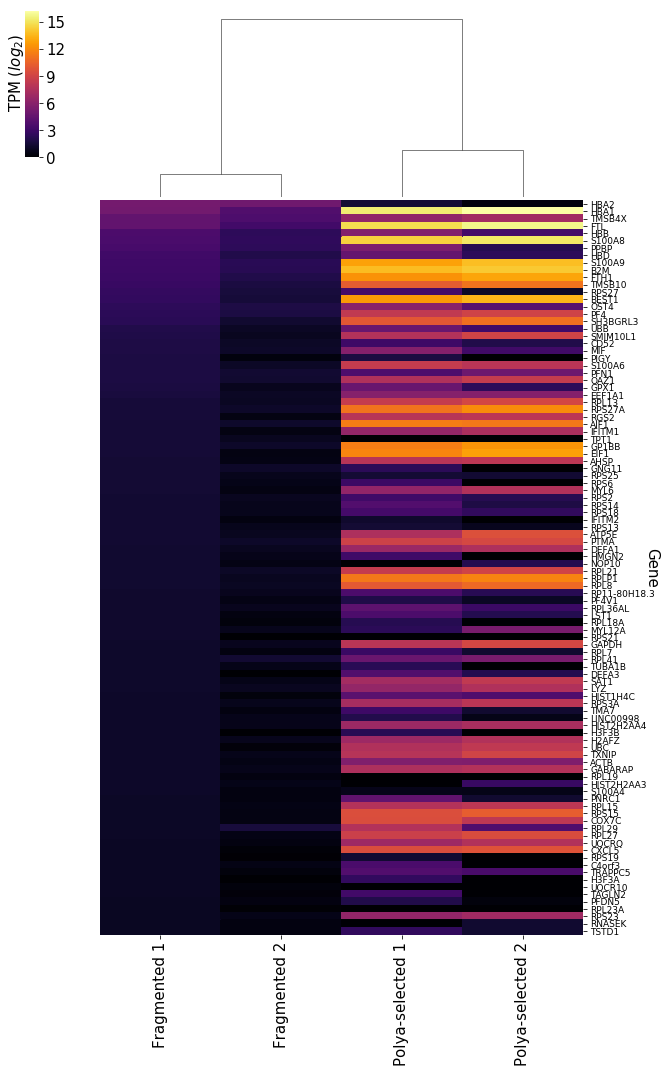

In [158]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.sort_values('Fragmented 1', ascending=False).iloc[:top_n,-4:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
yt = ax.set_yticks(np.arange(top_n)+0.5)
xt = ax.set_xticks(np.arange(4) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[-4:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

Text(0.1,0.85,'TPM ($log_2$)')

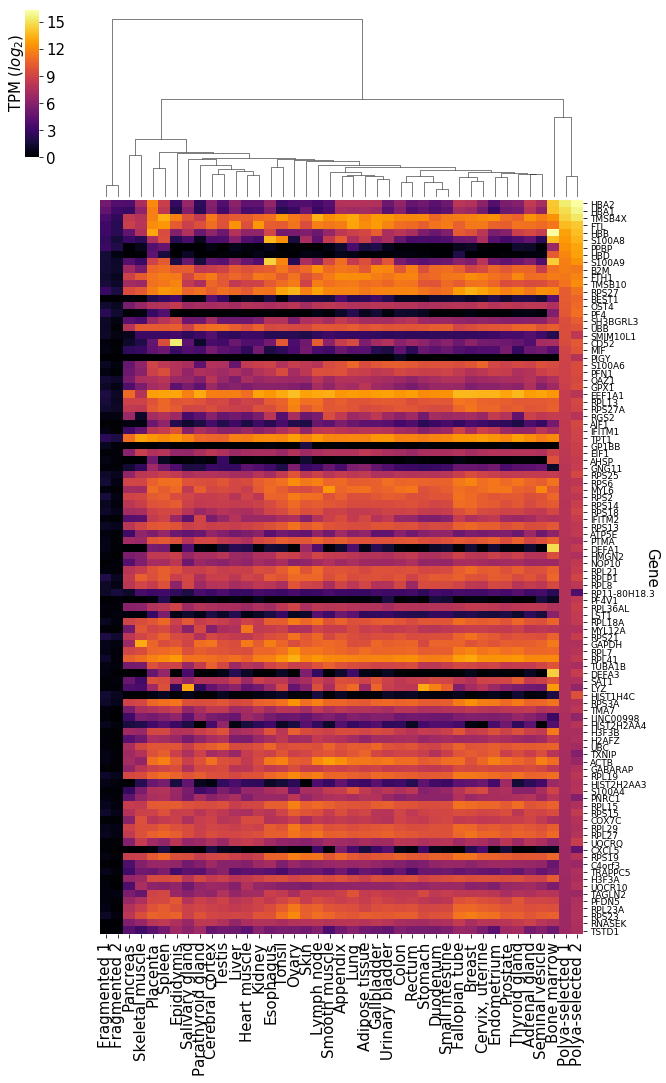

In [159]:
top_n = 100
p = sns.clustermap(np.log2(cor_df.iloc[:top_n,2:]+1),
                   row_cluster=False,
                  figsize = (10,17),
                  cmap = 'inferno')
ax = p.ax_heatmap
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(cor_df.shape[1] - 2) + 0.5)
xt = ax.set_xticklabels(cor_df.columns[2:].str.capitalize()[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 270)
p.fig.text(0.1,0.85, r'TPM ($log_2$)', rotation = 90, fontsize=15)

In [160]:
cor_df

,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,Fragmented 1,Fragmented 2,PolyA-selected 1,PolyA-selected 2
Gene name,,,,,,,,,,,,,,,,,,,,,
HBA2,ENSG00000188536,HBA2,226.0,336.7,218.0,18369.0,213.0,59.0,73.2,78.2,...,427.2,32.4,13.3,55.4,8.2,28.5,35.704413,13.274466,44524.056628,81123.189529
HBA1,ENSG00000206172,HBA1,142.9,233.6,143.1,17119.3,110.9,48.3,34.8,58.1,...,303.5,20.4,9.4,35.4,3.9,17.1,22.092479,8.622440,30029.377738,58483.819011
TMSB4X,ENSG00000205542,TMSB4X,3805.9,5439.9,6688.8,5468.2,3675.2,2891.0,4421.5,4173.9,...,10744.7,4224.3,928.3,1529.5,6487.7,5915.7,11.148292,5.005796,23372.040548,39180.756682
FTL,ENSG00000087086,FTL,4755.5,2291.2,3208.8,2600.5,2719.6,1997.8,2925.6,2081.9,...,5838.2,1280.3,889.4,2427.0,1209.1,3753.2,7.598477,4.005850,14150.935462,19022.544475
HBB,ENSG00000244734,HBB,627.5,654.3,306.3,78046.6,854.1,85.0,283.8,266.8,...,720.7,48.9,30.1,456.2,37.1,180.5,7.722315,4.257424,7679.651984,14790.969048
S100A8,ENSG00000143546,S100A8,464.5,22.0,1232.5,14915.7,36.9,11.7,176.7,25.4,...,786.1,10.9,13.0,12.6,4867.3,166.9,5.429674,2.120641,6360.982469,11773.855574
PPBP,ENSG00000163736,PPBP,2.3,1.4,1.6,110.6,1.1,0.5,0.1,0.2,...,24.3,0.1,0.0,1.6,0.0,0.7,7.188005,3.172727,5359.229551,8180.235775
HBD,ENSG00000223609,HBD,0.1,0.3,0.7,1221.3,0.0,0.0,0.0,0.4,...,2.2,0.2,0.1,0.1,0.1,0.1,1.907684,0.437811,3862.077819,7739.767711
S100A9,ENSG00000163220,S100A9,794.0,53.5,2087.4,20959.3,51.3,20.9,255.9,42.7,...,1188.6,17.2,16.6,29.3,3911.6,1006.1,1.942194,1.277762,3269.892422,5603.525130


In [161]:
tpm_df.head()

,id,grouped_type,type,name,200FQ_1_S4_R1_001,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001,glength
3,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,0.000000,0.000000,0.000000,0.000000,11321
4,ENSG00000000003,Protein coding,protein_coding,TSPAN6,0.0,28.648558,18.813655,1.112687,0.229782,11321
5,ENSG00000000005,Protein coding,protein_coding,TNMD,0.0,0.000000,0.000000,0.000000,0.000000,15083
6,ENSG00000000005,Protein coding,protein_coding,TNMD,0.0,10.751519,15.690173,0.278387,0.344939,15083
7,ENSG00000000419,Protein coding,protein_coding,DPM1,9.0,0.000000,0.000000,0.000000,0.000000,23688


Text(0.9,0.5,'TPM ($log_2$)')

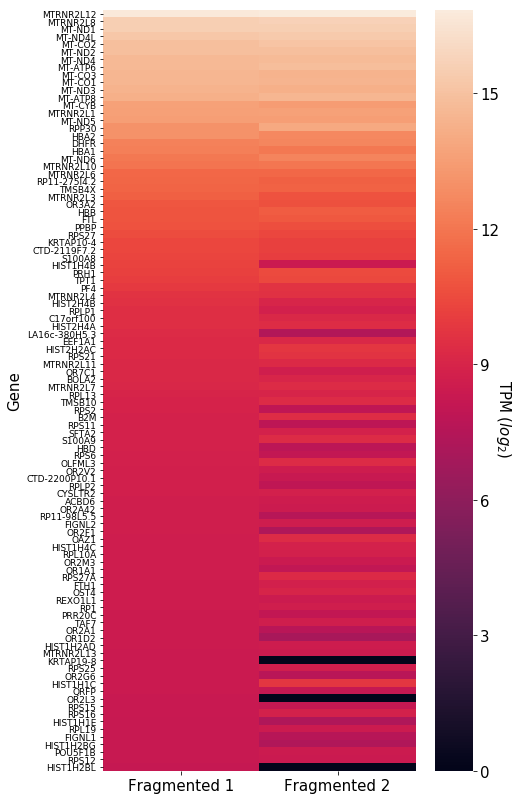

In [162]:
fig = plt.figure(figsize=(7,14))
ax = plt.subplot(111)
frag_df = tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')
p = sns.heatmap(np.log2(frag_df.iloc[:top_n,-2:]+1), ax =ax)
xt = ax.set_yticks(np.arange(top_n)+0.5)
yt = ax.set_xticks(np.arange(2) + 0.5)
xt = ax.set_xticklabels(frag_df.columns[-2:].map(rename_longRNA))
yt = ax.set_yticklabels(frag_df.index[:top_n], fontsize=9)
ax.set_ylabel('Gene', rotation = 90)
fig.text(0.9,0.5, r'TPM ($log_2$)', rotation = 270, fontsize=15)

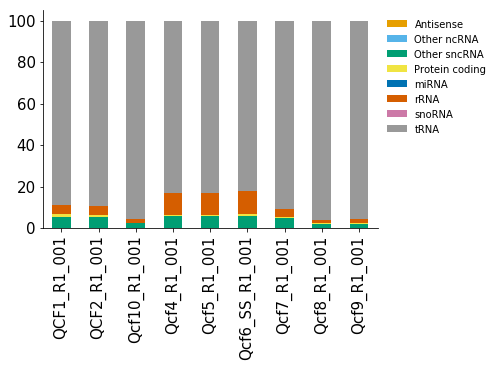

In [163]:
ax = plt.subplot(111)
count_df.filter(regex='grou|Q[cC][Ff][0-9]+')\
    .groupby('grouped_type')\
    .sum() \
    .pipe(percentage_columns)\
    .transpose() \
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1), frameon = False)
sns.despine()

In [164]:
dedup_df = pd.read_table('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv')
dedup_df.head()

,gene_id,gene_name,gene_type,grouped_type,200FN_1_S3_R1_001:all:antisense,200FN_1_S3_R1_001:all:sense,200FN_1_S3_R1_001:dedup:antisense,200FN_1_S3_R1_001:dedup:sense,200FQ_1_S4_R1_001:all:antisense,200FQ_1_S4_R1_001:all:sense,...,Qcf_Na1_R1_001:dedup:antisense,Qcf_Na1_R1_001:dedup:sense,S96-cfD_R1_001:all:antisense,S96-cfD_R1_001:all:sense,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense
0,18S_rRNA,18S_rRNA,rDNA,rDNA,1789,1253493,1408,867335,2500,1591132,...,901,1880,575,105388,359,46970,945,113126,583,48893
1,28S_rRNA,28S_rRNA,rDNA,rDNA,1795,2636287,1447,1692392,2133,2677238,...,1422,4006,1006,277376,597,109543,1340,296715,787,113377
2,5.8S_rRNA,5.8S_rRNA,rDNA,rDNA,135,116389,110,44882,127,111788,...,101,294,67,362407,32,15992,74,386566,34,16284
3,5S_rRNA,5S_rRNA,rDNA,rDNA,27,48855,21,18586,79,162867,...,65,157,6,3413,5,1355,6,3607,5,1393
4,Alu,SINE:AluJb,Repeats,Repeats,197,209,169,169,403,787,...,39517,47502,3022,2676,1727,1418,3315,3042,1865,1632


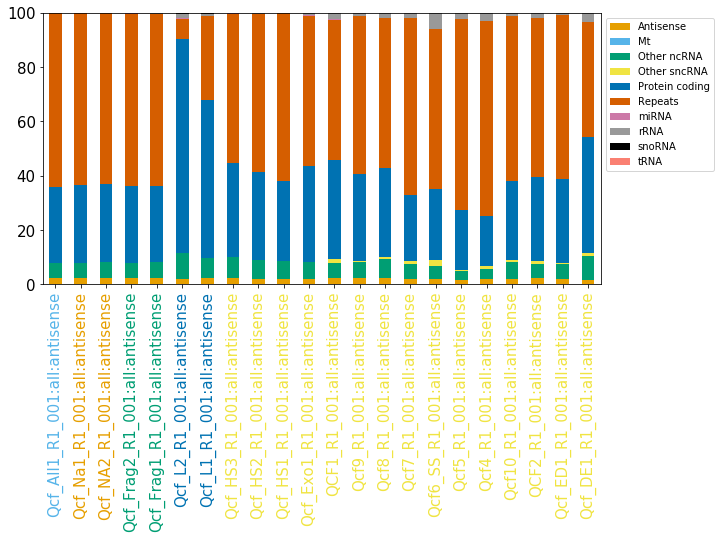

In [165]:
from tgirt_map.table_tool import change_gene_type
from sequencing_tools.viz_tools import color_encoder, simpsons_palette

def label_treatment(x, return_label=False):
    if 'All' in x:
        return 'Total nucleic acid' if return_label else 1
    elif re.search('NA|Na', x):
        return 'Alkaline hydrolysis' if return_label else 2
    elif re.search('Frag|frag', x):
        return 'Fragmented' if return_label else 3
    elif re.search('L[12]', x):
        return 'PolyA-selected' if return_label else 4
    else:
        return 'DNase-treatment' if return_label else 5

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
colors.append('salmon')
dedup_df\
    .assign(gene_type = lambda d: d.gene_type.map(change_gene_type))\
    .filter(regex = 'type|Qcf|QCF')\
    .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
    .groupby('grouped_type')\
    .sum() \
    .pipe(lambda d: d[d.columns[d.columns.str.contains('anti')]])\
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('dedup')]])\
    .pipe(percentage_columns)\
    .transpose() \
    .assign(prep = lambda d: d.index.map(label_treatment))\
    .sort_values('prep')\
    .drop('prep', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = colors)
ax.legend(bbox_to_anchor = (1,1))

preps = [label_treatment(_.get_text(), return_label=True) for _ in ax.get_xmajorticklabels()]
ce = color_encoder()
ce.fit(preps)
for _, pre in zip(ax.get_xmajorticklabels(),preps):
    _.set_color(ce.encoder[pre])

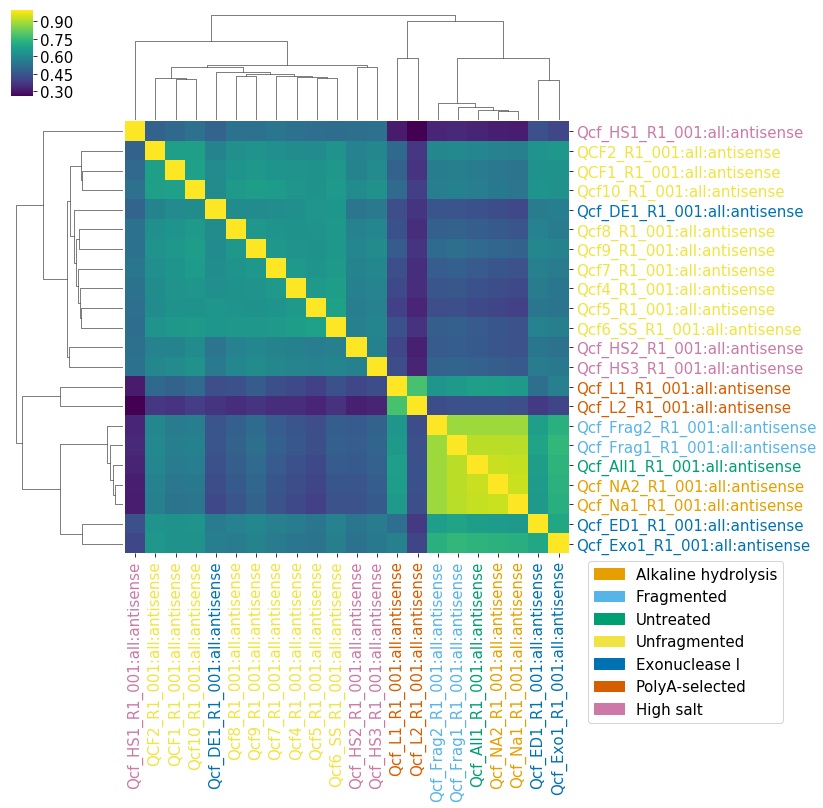

In [176]:
cor_df = np.log(dedup_df.filter(regex = 'Qcf|QCF').filter(regex='all:antisense')+1).corr()
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.map(label_sample), 
                 okabeito_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[label_sample(xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[label_sample(yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.5,0.), fontsize=15)

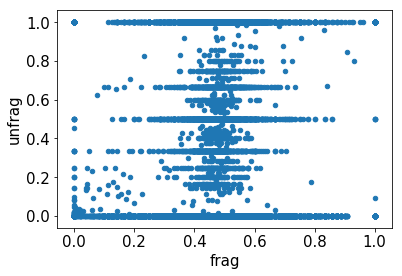

In [166]:
def frac(x, y):
    return x/(x+y)

sense_df = dedup_df\
    .filter(regex = 'Frag1.*dedup|QCF1_.*dedup|type|name|id')  \
    .assign(frag = lambda d: frac(d['Qcf_Frag1_R1_001:dedup:antisense'], d['Qcf_Frag1_R1_001:dedup:sense'])) \
    .assign(unfrag = lambda d: frac(d['QCF1_R1_001:dedup:antisense'],d['QCF1_R1_001:dedup:sense']))  \
    .query('grouped_type != "Repeats"') \
    .replace([np.inf, -np.inf], np.nan)\
    .fillna(0)
sense_df.plot.scatter('frag','unfrag')

In [167]:
sense_df.query('frag > unfrag').sort_values('frag', ascending=False).pipe(lambda d: d[d['QCF1_R1_001:dedup:antisense']>10])

,gene_id,gene_name,gene_type,grouped_type,QCF1_R1_001:dedup:antisense,QCF1_R1_001:dedup:sense,Qcf_Frag1_R1_001:dedup:antisense,Qcf_Frag1_R1_001:dedup:sense,frag,unfrag
12470,ENSG00000167995,BEST1,protein_coding,Protein coding,11,2,59,6,0.907692,0.846154
3117,ENSG00000104904,OAZ1,protein_coding,Protein coding,209,103,196,37,0.841202,0.669872
30271,ENSG00000230021,RP5-857K21.4,lincRNA,Other ncRNA,157,741,1254,338,0.787688,0.174833
27963,ENSG00000226745,RP11-115D7.3,pseudogene,Other ncRNA,12,9,4,2,0.666667,0.571429
18298,ENSG00000198727,MT-CYB,protein_coding,Protein coding,12,39,226,488,0.316527,0.235294
0,18S_rRNA,18S_rRNA,rDNA,rDNA,208,85491,1858,663189,0.002794,0.002427
1,28S_rRNA,28S_rRNA,rDNA,rDNA,299,175916,1808,1063269,0.001698,0.001697
42394,ENSG00000252316,RNY4,misc_RNA,Other sncRNA,65,76826,16,14547,0.001099,0.000845


In [168]:
count_df\
    .filter(regex='L[12]|Frag[12]|id|name') \
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .iloc[20:70,:]

,id,name,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001,Qcf_L1_R1_001,Qcf_L2_R1_001
123808,MT-TE,MT-TE,11018.0,25910.0,395.0,161.0
124196,TRV-CAC10-1,TRV-CAC10-1,10385.0,81093.0,177.0,46.0
123949,TRG-GCC5-1,TRG-GCC5-1,9522.0,51300.0,209.0,36.0
124174,TRU-TCA1-1,TRU-TCA1-1,8686.0,52851.0,362.0,74.0
106518,ENSG00000265150.1,RN7SL2,8621.0,11684.0,24.0,29.0
122431,ENSG00000283029.1_4,RN7SL1,8102.0,10055.0,21.0,32.0
123818,MT-TP,MT-TP,7488.0,11592.0,184.0,62.0
123975,TRIMET-CAT2-1,TRIMET-CAT2-1,6201.0,43632.0,261.0,62.0
59713,ENSG00000228716.6_3,DHFR,5781.0,7503.0,1352.0,2333.0
123942,TRG-CCC8-1,TRG-CCC8-1,5650.0,36168.0,197.0,41.0


In [169]:
tpm_df\
    .filter(regex='id|name|type|Frag')\
    .sort_values('Qcf_Frag1_R1_001', ascending=False)\
    .set_index('name')

,id,grouped_type,type,Qcf_Frag1_R1_001,Qcf_Frag2_R1_001
name,,,,,
MTRNR2L12,ENSG00000269028,Protein coding,protein_coding,108958.861201,118350.662089
MTRNR2L8,ENSG00000255823,Protein coding,protein_coding,49295.357023,54252.533573
MT-ND1,ENSG00000198888,Protein coding,protein_coding,47885.418981,48247.857909
MT-ND4L,ENSG00000212907,Protein coding,protein_coding,38623.796560,42453.965881
MT-CO2,ENSG00000198712,Protein coding,protein_coding,31340.850839,35480.906697
MT-ND2,ENSG00000198763,Protein coding,protein_coding,30376.759082,30985.647993
MT-ND4,ENSG00000198886,Protein coding,protein_coding,26105.018498,26294.986191
MT-ATP6,ENSG00000198899,Protein coding,protein_coding,25358.179435,30069.090092
MT-CO3,ENSG00000198938,Protein coding,protein_coding,23851.878582,21187.109563
